In [1]:
# To visualize plots in the notebook
%matplotlib inline

import numpy as np
import pandas as pd # To read data tables from csv files
import seaborn as sns # To plot statistical graphics
import matplotlib.pyplot as plt # To plot the figures

import os
from termcolor import colored
import tqdm
import scipy
import gc

# For plots and graphical results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

# That's default image size for this interactive session
pylab.rcParams['figure.figsize'] = 9, 6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar los datos desde el archivo JSON
data_path = '/content/drive/My Drive/proyecto/full_format_recipes.json'  # Clara
#data_path = '/content/drive/My Drive/Colab Notebooks/proyecto/full_format_recipes.json'  # Jorge
recipes_df = pd.read_json(data_path)

import scipy.sparse
# Cargamos la matriz TF-IDF
matriz_tfidf = scipy.sparse.load_npz('/content/drive/My Drive/proyecto/TFIDF.npz')

Mounted at /content/drive


### **1. Preparación de los datos de entrenamiento y de test**

In [3]:
from re import X
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


target = recipes_df['rating']
print(min(target)) #0
print(max(target)) #5
target = target.fillna(target.mean()) # Relleno los valores que faltan (NaN) con media

# Dividimos los datos en conjunto de entrenamiento y de test, features (X) y labels (y)
X_train, X_test, y_train, y_test = train_test_split(matriz_tfidf, target, test_size=0.2, random_state=42)

# Normalizamos los datos para que tengan media cero y varianza unidad de forma
# que mejore el funcionamiento del algoritmo
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


0.0
5.0


### **2. Entrenamiento y evaluación**

#### ***Red neuronal con PyTorch***

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# Convertimos los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

###***CASO MÁS RÁPIDO, MENOS EFICIENTE***

**Número de épocas = 5**

**Tamaño de batch = 128**

**Learning Rate = 0.1**

In [6]:
# Creamos TensorDataset (combina características y etiquetas en un único objeto)
# y DataLoader (proporciona lotes de datos de un tamaño específico (batch_size))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


# Definimos la red neuronal
class Net(nn.Module):
    # Inicialización capas de la red (3)
    def __init__(self, input_size):
        super(Net, self).__init__()
        # En cada capa se reducen las dimensiones a 128, 64, y 1
        # Esto ayuda a aprender representaciones más abstractas de los datos a medida que se avanza a través de las capas
        # 128 y 64 son valores comunes para redes pequeñas
        # 1: la capa de salida tiene solo 1 neurona porque estamos prediciendo un valor continuo (rating receta)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    # Definimos cómo fluyen los datos a través de las capas: hacia adelante
    # Funcion de activacion ReLU (Rectified Linear Unit) que se aplica a la salida de una capa
    # antes de pasarla a la sigueinte capa
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Creamos una instancia del modelo

# Obtenemos el tamaño de la entrada de la red basandonos en el número de palabras (columnas)
# en los datos de entrenamiento
input_size = X_train_tensor.shape[1]

# Inicializamos la red con la arquitectura y tamaños de capa especificados
model = Net(input_size)

# Las función de pérdida que usaremos para evaluar será MSE
criterion = nn.MSELoss()  # For regression
# Definimos el optimizador, con el que se ajustarán los pesos de la red durante el entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Entrenamos el modelo
# Las épocas de entrenamiento son las veces que se pasa el conjunto de datos a través de la red
epochs = 5
# Iteramos para cada lote en cada éopca
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #Reiniciamos los gradientes calculados en la iteracion anterior
        optimizer.zero_grad()
        #Obtenemos las predicciones del lote actual
        output = model(data)
        #Calculamos el error (loss) entre las predicciones y los valores reales
        loss = criterion(output, target.unsqueeze(1))
        #Calculamos los gradientes de pérdida con respecto a los pesos de la red
        loss.backward()
        #Actualizamos los pesos de la red con los gradientes calculados para minimizar la pérdida
        optimizer.step()

In [7]:
# Realizamos predicciones en el conjunto de evaluación
with torch.no_grad():  # Desactivamos el cálculo de gradientes durante la predicción
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_pred = model(X_test_tensor)

# Convertimos las predicciones a un array NumPy
y_pred_np = y_pred.cpu().numpy().flatten()

# Calculamos el error cuadrático medio (MSE)
mse_peor = mean_squared_error(y_test, y_pred_np)
print("Error cuadrático medio (MSE):", mse_peor)

# Calcular el R-cuadrado
r2_peor = r2_score(y_test, y_pred_np)
print("R-cuadrado:", r2_peor)

Error cuadrático medio (MSE): 1.80972066309817
R-cuadrado: -0.0028706040594195237


###***AUMENTAMOS LAS ÉPOCAS***

**Número de épocas = 20**

**Tamaño de batch = 128**

**Learning Rate = 0.1**

In [10]:
# Creamos TensorDataset (combina características y etiquetas en un único objeto)
# y DataLoader (proporciona lotes de datos de un tamaño específico (batch_size))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


# Define the neural network model
class Net(nn.Module):
    # Inicialización capas de la red (3)
    def __init__(self, input_size):
        super(Net, self).__init__()
        # En cada capa se reducen las dimensiones a 128, 64, y 1
        # Esto ayuda a aprender representaciones más abstractas de los datos a medida que se avanza a través de las capas
        # 128 y 64 son valores comunes para redes pequeñas
        # 1: la capa de salida tiene solo 1 neurona porque estamos prediciendo un valor continuo (rating receta)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    # Definimos cómo fluyen los datos a través de las capas: hacia adelante
    # Funcion de activacion ReLU (Rectified Linear Unit) que se aplica a la salida de una capa
    # antes de pasarla a la sigueinte capa
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Creamos una instancia del modelo

# Obtenemos el tamaño de la entrada de la red basandonos en el número de palabras (columnas)
# en los datos de entrenamiento
input_size = X_train_tensor.shape[1]

# Inicializamos la red con la arquitectura y tamaños de capa especificados
model = Net(input_size)

# Las función de pérdida que usaremos para evaluar será MSE
criterion = nn.MSELoss()  # For regression
# Definimos el optimizador, con el que se ajustarán los pesos de la red durante el entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Entrenamos el modelo
# Las épocas de entrenamiento son las veces que se pasa el conjunto de datos a través de la red
epochs = 20
# Iteramos para cada lote en cada éopca
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #Reiniciamos los gradientes calculados en la iteracion anterior
        optimizer.zero_grad()
        #Obtenemos las predicciones del lote actual
        output = model(data)
        #Calculamos el error (loss) entre las predicciones y los valores reales
        loss = criterion(output, target.unsqueeze(1))
        #Calculamos los gradientes de pérdida con respecto a los pesos de la red
        loss.backward()
        #Actualizamos los pesos de la red con los gradientes calculados para minimizar la pérdida
        optimizer.step()

In [11]:
# Realizamos predicciones en el conjunto de evaluación
with torch.no_grad():  # Desactivamos el cálculo de gradientes durante la predicción
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_pred = model(X_test_tensor)

# Convertimos las predicciones a un array NumPy
y_pred_np = y_pred.cpu().numpy().flatten()

# Calculamos el error cuadrático medio (MSE)
mse_epocas = mean_squared_error(y_test, y_pred_np)
print("Error cuadrático medio (MSE):", mse_epocas)

# Calcular el R-cuadrado
r2_epocas = r2_score(y_test, y_pred_np)
print("R-cuadrado:", r2_epocas)

Error cuadrático medio (MSE): 1.9041127176371688
R-cuadrado: -0.05517868601051812


###***DISMINUIMOS EL TAMAÑO DE BATCH***

**Número de épocas = 5**

**Tamaño de batch = 32**

**Learning Rate = 0.1**

In [ ]:
# Creamos TensorDataset (combina características y etiquetas en un único objeto)
# y DataLoader (proporciona lotes de datos de un tamaño específico (batch_size))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Define the neural network model
class Net(nn.Module):
    # Inicialización capas de la red (3)
    def __init__(self, input_size):
        super(Net, self).__init__()
        # En cada capa se reducen las dimensiones a 128, 64, y 1
        # Esto ayuda a aprender representaciones más abstractas de los datos a medida que se avanza a través de las capas
        # 128 y 64 son valores comunes para redes pequeñas
        # 1: la capa de salida tiene solo 1 neurona porque estamos prediciendo un valor continuo (rating receta)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    # Definimos cómo fluyen los datos a través de las capas: hacia adelante
    # Funcion de activacion ReLU (Rectified Linear Unit) que se aplica a la salida de una capa
    # antes de pasarla a la sigueinte capa
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Creamos una instancia del modelo

# Obtenemos el tamaño de la entrada de la red basandonos en el número de palabras (columnas)
# en los datos de entrenamiento
input_size = X_train_tensor.shape[1]

# Inicializamos la red con la arquitectura y tamaños de capa especificados
model = Net(input_size)

# Las función de pérdida que usaremos para evaluar será MSE
criterion = nn.MSELoss()  # For regression
# Definimos el optimizador, con el que se ajustarán los pesos de la red durante el entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Entrenamos el modelo
# Las épocas de entrenamiento son las veces que se pasa el conjunto de datos a través de la red
epochs = 5
# Iteramos para cada lote en cada éopca
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #Reiniciamos los gradientes calculados en la iteracion anterior
        optimizer.zero_grad()
        #Obtenemos las predicciones del lote actual
        output = model(data)
        #Calculamos el error (loss) entre las predicciones y los valores reales
        loss = criterion(output, target.unsqueeze(1))
        #Calculamos los gradientes de pérdida con respecto a los pesos de la red
        loss.backward()
        #Actualizamos los pesos de la red con los gradientes calculados para minimizar la pérdida
        optimizer.step()

In [ ]:
# Realizamos predicciones en el conjunto de evaluación
with torch.no_grad():  # Desactivamos el cálculo de gradientes durante la predicción
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_pred = model(X_test_tensor)

# Convertir las predicciones a un array NumPy
y_pred_np = y_pred.cpu().numpy().flatten()

# Calcular el error cuadrático medio (MSE)
mse_batch = mean_squared_error(y_test, y_pred_np)
print("Error cuadrático medio (MSE):", mse_batch)

# Calcular el R-cuadrado
r2_batch = r2_score(y_test, y_pred_np)
print("R-cuadrado:", r2_batch)

Error cuadrático medio (MSE): 1.8046187321474543
R-cuadrado: -4.332984039479015e-05


###***REDUCIMOS EL LEARNING RATE***

**Número de épocas = 5**

**Tamaño de batch = 128**

**Learning Rate = 0.001**

In [ ]:
# Creamos TensorDataset (combina características y etiquetas en un único objeto)
# y DataLoader (proporciona lotes de datos de un tamaño específico (batch_size))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


# Define the neural network model
class Net(nn.Module):
    # Inicialización capas de la red (3)
    def __init__(self, input_size):
        super(Net, self).__init__()
        # En cada capa se reducen las dimensiones a 128, 64, y 1
        # Esto ayuda a aprender representaciones más abstractas de los datos a medida que se avanza a través de las capas
        # 128 y 64 son valores comunes para redes pequeñas
        # 1: la capa de salida tiene solo 1 neurona porque estamos prediciendo un valor continuo (rating receta)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    # Definimos cómo fluyen los datos a través de las capas: hacia adelante
    # Funcion de activacion ReLU (Rectified Linear Unit) que se aplica a la salida de una capa
    # antes de pasarla a la sigueinte capa
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Creamos una instancia del modelo

# Obtenemos el tamaño de la entrada de la red basandonos en el número de palabras (columnas)
# en los datos de entrenamiento
input_size = X_train_tensor.shape[1]

# Inicializamos la red con la arquitectura y tamaños de capa especificados
model = Net(input_size)

# Las función de pérdida que usaremos para evaluar será MSE
criterion = nn.MSELoss()  # For regression
# Definimos el optimizador, con el que se ajustarán los pesos de la red durante el entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamos el modelo
# Las épocas de entrenamiento son las veces que se pasa el conjunto de datos a través de la red
epochs = 5
# Iteramos para cada lote en cada éopca
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #Reiniciamos los gradientes calculados en la iteracion anterior
        optimizer.zero_grad()
        #Obtenemos las predicciones del lote actual
        output = model(data)
        #Calculamos el error (loss) entre las predicciones y los valores reales
        loss = criterion(output, target.unsqueeze(1))
        #Calculamos los gradientes de pérdida con respecto a los pesos de la red
        loss.backward()
        #Actualizamos los pesos de la red con los gradientes calculados para minimizar la pérdida
        optimizer.step()

In [ ]:
# Realizamos predicciones en el conjunto de test
with torch.no_grad():  # Desactivamos el cálculo de gradientes durante la predicción
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_pred = model(X_test_tensor)

# Convertir las predicciones a un array NumPy
y_pred_np = y_pred.cpu().numpy().flatten()

# Calcular el error cuadrático medio (MSE)
mse_lr = mean_squared_error(y_test, y_pred_np)
print("Error cuadrático medio (MSE):", mse_lr)

# Calcular el R-cuadrado
r2_lr = r2_score(y_test, y_pred_np)
print("R-cuadrado:", r2_lr)

Error cuadrático medio (MSE): 1.8270227274661337
R-cuadrado: -0.012458675908292083


###***CASO MÁS LENTO, MÁS EFICIENTE***

**Número de épocas = 20**

**Tamaño de batch = 32**

**Learning Rate = 0.001**

In [8]:
# Creamos TensorDataset (combina características y etiquetas en un único objeto)
# y DataLoader (proporciona lotes de datos de un tamaño específico (batch_size))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Define the neural network model
class Net(nn.Module):
    # Inicialización capas de la red (3)
    def __init__(self, input_size):
        super(Net, self).__init__()
        # En cada capa se reducen las dimensiones a 128, 64, y 1
        # Esto ayuda a aprender representaciones más abstractas de los datos a medida que se avanza a través de las capas
        # 128 y 64 son valores comunes para redes pequeñas
        # 1: la capa de salida tiene solo 1 neurona porque estamos prediciendo un valor continuo (rating receta)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    # Definimos cómo fluyen los datos a través de las capas: hacia adelante
    # Funcion de activacion ReLU (Rectified Linear Unit) que se aplica a la salida de una capa
    # antes de pasarla a la sigueinte capa
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Creamos una instancia del modelo

# Obtenemos el tamaño de la entrada de la red basandonos en el número de palabras (columnas)
# en los datos de entrenamiento
input_size = X_train_tensor.shape[1]

# Inicializamos la red con la arquitectura y tamaños de capa especificados
model = Net(input_size)

# Las función de pérdida que usaremos para evaluar será MSE
criterion = nn.MSELoss()  # For regression
# Definimos el optimizador, con el que se ajustarán los pesos de la red durante el entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamos el modelo
# Las épocas de entrenamiento son las veces que se pasa el conjunto de datos a través de la red
epochs = 20
# Iteramos para cada lote en cada éopca
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #Reiniciamos los gradientes calculados en la iteracion anterior
        optimizer.zero_grad()
        #Obtenemos las predicciones del lote actual
        output = model(data)
        #Calculamos el error (loss) entre las predicciones y los valores reales
        loss = criterion(output, target.unsqueeze(1))
        #Calculamos los gradientes de pérdida con respecto a los pesos de la red
        loss.backward()
        #Actualizamos los pesos de la red con los gradientes calculados para minimizar la pérdida
        optimizer.step()

In [9]:
# Realizamos predicciones en el conjunto de test
with torch.no_grad():  # Desactivamos el cálculo de gradientes durante la predicción
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_pred = model(X_test_tensor)

# Convertir las predicciones a un array NumPy
y_pred_np = y_pred.cpu().numpy().flatten()  # Convertir a NumPy y aplanar

# Calcular el error cuadrático medio (MSE)
mse_mejor = mean_squared_error(y_test, y_pred_np)
print("Error cuadrático medio (MSE):", mse_mejor)

# Calcular el R-cuadrado
r2_mejor = r2_score(y_test, y_pred_np)
print("R-cuadrado:", r2_mejor)

Error cuadrático medio (MSE): 1.6310237211452596
R-cuadrado: 0.09615567871125186


*Comparamos gráficamente los resultados.*

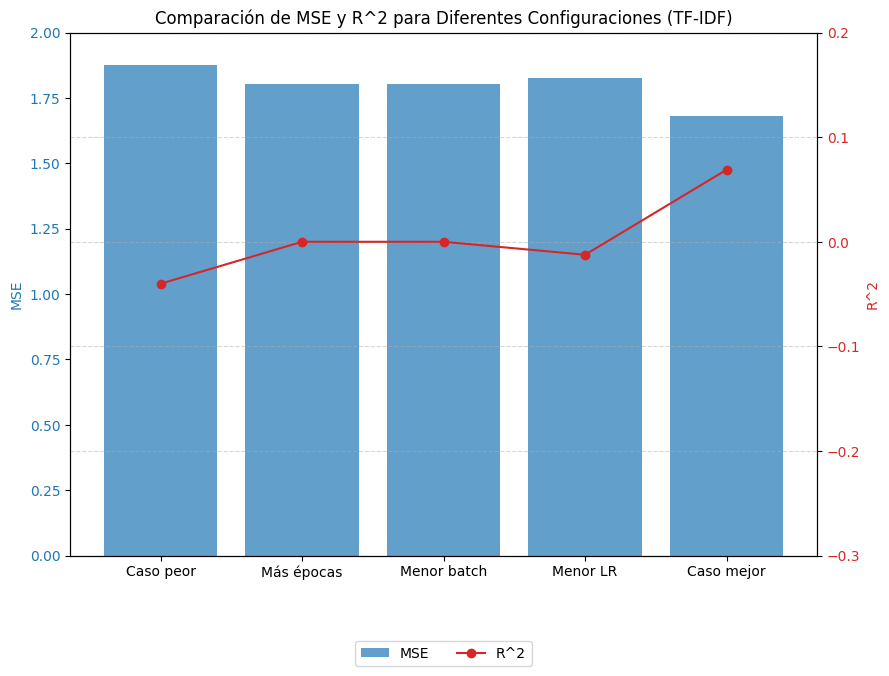

In [ ]:
mse_values = [mse_peor, mse_epocas, mse_batch, mse_lr, mse_mejor]
r2_values = [r2_peor, r2_epocas, r2_batch, r2_lr, r2_mejor]
labels = ['Caso peor', 'Más épocas', 'Menor batch', 'Menor LR', 'Caso mejor']


fig, ax1 = plt.subplots()

# Eje MSE
ax1.bar(labels, mse_values, color='tab:blue', label='MSE', alpha=0.7)
ax1.set_ylabel('MSE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 2)

# Eje R^2
ax2 = ax1.twinx()
ax2.plot(labels, r2_values, color='tab:red', marker='o', label='R^2')
ax2.set_ylabel('R^2', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(-0.3, 0.2)


plt.title('Comparación de MSE y R^2 para Diferentes Configuraciones (TF-IDF)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)

# Leyenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Mostrar la gráfica
plt.show()

###***AUMENTAMOS EN 2 EL NÚMERO DE CAPAS, MEJOR CASO***

**Número de épocas = 20**

**Tamaño de batch = 32**

**Learning Rate = 0.001**

In [ ]:
# Creamos TensorDataset (combina características y etiquetas en un único objeto)
# y DataLoader (proporciona lotes de datos de un tamaño específico (batch_size))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Define the neural network model
class Net(nn.Module):
    # Inicialización capas de la red (3)
    def __init__(self, input_size):
        super(Net, self).__init__()
        # En cada capa se reducen las dimensiones a 128, 64, y 1
        # Esto ayuda a aprender representaciones más abstractas de los datos a medida que se avanza a través de las capas
        # 128 y 64 son valores comunes para redes pequeñas
        # 1: la capa de salida tiene solo 1 neurona porque estamos prediciendo un valor continuo (rating receta)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32) # Nueva capa
        self.fc4 = nn.Linear(32, 16) # Nueva capa
        self.fc5 = nn.Linear(16, 1)  # Capa de salida

    # Definimos cómo fluyen los datos a través de las capas: hacia adelante
    # Funcion de activacion ReLU (Rectified Linear Unit) que se aplica a la salida de una capa
    # antes de pasarla a la sigueinte capa
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


# Creamos una instancia del modelo

# Obtenemos el tamaño de la entrada de la red basandonos en el número de palabras (columnas)
# en los datos de entrenamiento
input_size = X_train_tensor.shape[1]

# Inicializamos la red con la arquitectura y tamaños de capa especificados
model = Net(input_size)

# Las función de pérdida que usaremos para evaluar será MSE
criterion = nn.MSELoss()  # For regression
# Definimos el optimizador, con el que se ajustarán los pesos de la red durante el entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamos el modelo
# Las épocas de entrenamiento son las veces que se pasa el conjunto de datos a través de la red
epochs = 20
# Iteramos para cada lote en cada éopca
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #Reiniciamos los gradientes calculados en la iteracion anterior
        optimizer.zero_grad()
        #Obtenemos las predicciones del lote actual
        output = model(data)
        #Calculamos el error (loss) entre las predicciones y los valores reales
        loss = criterion(output, target.unsqueeze(1))
        #Calculamos los gradientes de pérdida con respecto a los pesos de la red
        loss.backward()
        #Actualizamos los pesos de la red con los gradientes calculados para minimizar la pérdida
        optimizer.step()

In [ ]:
# Realizamos predicciones en el conjunto de test
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_pred = model(X_test_tensor)

# Convertir las predicciones a un array NumPy
y_pred_np = y_pred.cpu().numpy().flatten()

# Calcular el error cuadrático medio (MSE)
mse_capa_mejor = mean_squared_error(y_test, y_pred_np)
print("Error cuadrático medio (MSE):", mse_capa_mejor)

# Calcular el R-cuadrado
r2_capa_mejor = r2_score(y_test, y_pred_np)
print("R-cuadrado:", r2_capa_mejor)

Error cuadrático medio (MSE): 1.693886114253946
R-cuadrado: 0.06132000078866984


###***AUMENTAMOS EN 2 EL NÚMERO DE CAPAS, PEOR CASO***

**Número de épocas = 5**

**Tamaño de batch = 128**

**Learning Rate = 0.1**

In [ ]:
# Creamos TensorDataset (combina características y etiquetas en un único objeto)
# y DataLoader (proporciona lotes de datos de un tamaño específico (batch_size))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


# Define the neural network model
class Net(nn.Module):
    # Inicialización capas de la red (3)
    def __init__(self, input_size):
        super(Net, self).__init__()
        # En cada capa se reducen las dimensiones a 128, 64, y 1
        # Esto ayuda a aprender representaciones más abstractas de los datos a medida que se avanza a través de las capas
        # 128 y 64 son valores comunes para redes pequeñas
        # 1: la capa de salida tiene solo 1 neurona porque estamos prediciendo un valor continuo (rating receta)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32) # Nueva capa
        self.fc4 = nn.Linear(32, 16) # Nueva capa
        self.fc5 = nn.Linear(16, 1)  # Capa de salida

    # Definimos cómo fluyen los datos a través de las capas: hacia adelante
    # Funcion de activacion ReLU (Rectified Linear Unit) que se aplica a la salida de una capa
    # antes de pasarla a la sigueinte capa
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


# Creamos una instancia del modelo

# Obtenemos el tamaño de la entrada de la red basandonos en el número de palabras (columnas)
# en los datos de entrenamiento
input_size = X_train_tensor.shape[1]

# Inicializamos la red con la arquitectura y tamaños de capa especificados
model = Net(input_size)

# Las función de pérdida que usaremos para evaluar será MSE
criterion = nn.MSELoss()  # For regression
# Definimos el optimizador, con el que se ajustarán los pesos de la red durante el entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Entrenamos el modelo
# Las épocas de entrenamiento son las veces que se pasa el conjunto de datos a través de la red
epochs = 5
# Iteramos para cada lote en cada éopca
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #Reiniciamos los gradientes calculados en la iteracion anterior
        optimizer.zero_grad()
        #Obtenemos las predicciones del lote actual
        output = model(data)
        #Calculamos el error (loss) entre las predicciones y los valores reales
        loss = criterion(output, target.unsqueeze(1))
        #Calculamos los gradientes de pérdida con respecto a los pesos de la red
        loss.backward()
        #Actualizamos los pesos de la red con los gradientes calculados para minimizar la pérdida
        optimizer.step()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Realizar predicciones en el conjunto de test
with torch.no_grad():  # Desactivar el cálculo de gradientes durante la predicción
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_pred = model(X_test_tensor)

# Convertir las predicciones a un array NumPy
y_pred_np = y_pred.cpu().numpy().flatten()  # Convertir a NumPy y aplanar

# Calcular el error cuadrático medio (MSE)
# Menor MSE = mejor rendimiento del modelo
mse_capa_peor = mean_squared_error(y_test, y_pred_np)
print("Error cuadrático medio (MSE):", mse_capa_peor)

# Calcular el R-cuadrado (proporción de la varianza en los ratings)
# Mayor R = mejor ajuste del modelo a los datos
r2_capa_peor = r2_score(y_test, y_pred_np)
print("R-cuadrado:", r2_capa_peor)

Error cuadrático medio (MSE): 1.7219921472925108
R-cuadrado: 0.04574482672680946


*Vemos gráficamente el impacto de aumentar el número de capas.*

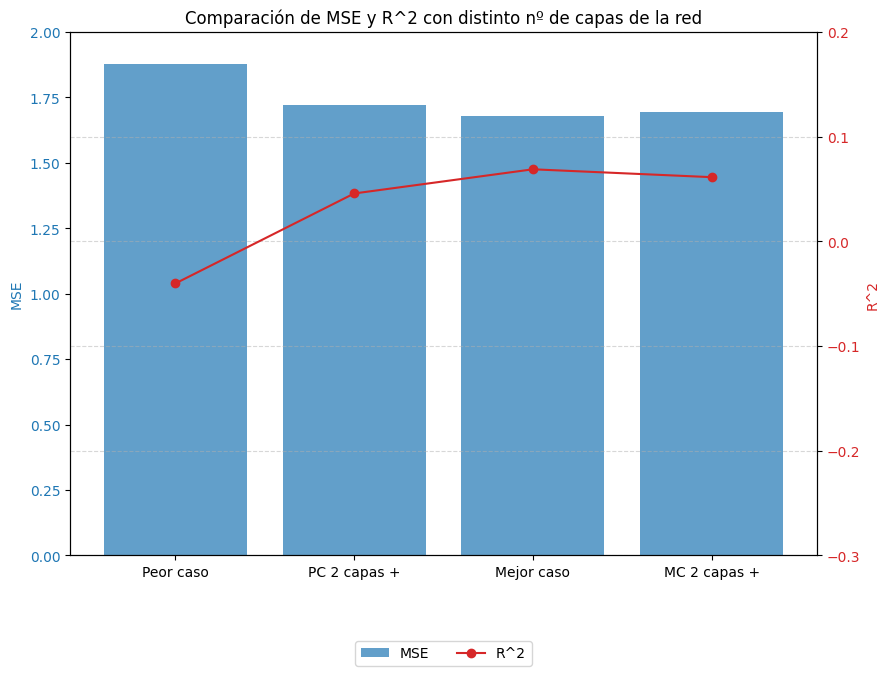

In [ ]:
# Datos para la gráfica
mse_values = [mse_peor, mse_capa_peor, mse_mejor, mse_capa_mejor]
r2_values = [r2_peor, r2_capa_peor, r2_mejor, r2_capa_mejor]
labels = ['Peor caso', 'PC 2 capas +', 'Mejor caso', 'MC 2 capas +']

# Crear la gráfica
fig, ax1 = plt.subplots()

# Eje MSE
ax1.bar(labels, mse_values, color='tab:blue', label='MSE', alpha=0.7)
ax1.set_ylabel('MSE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 2)

# Eje R^2
ax2 = ax1.twinx()
ax2.plot(labels, r2_values, color='tab:red', marker='o', label='R^2')
ax2.set_ylabel('R^2', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(-0.3, 0.2)

# Ajustes adicionales
plt.title('Comparación de MSE y R^2 con distinto nº de capas de la red')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar leyenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Mostrar la gráfica
plt.show()

###***100 ÉPOCAS***

**Número de épocas = 100**

**Tamaño de batch = 32**

**Learning Rate = 0.001**

In [13]:
# Creamos TensorDataset (combina características y etiquetas en un único objeto)
# y DataLoader (proporciona lotes de datos de un tamaño específico (batch_size))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Define the neural network model
class Net(nn.Module):
    # Inicialización capas de la red (3)
    def __init__(self, input_size):
        super(Net, self).__init__()
        # En cada capa se reducen las dimensiones a 128, 64, y 1
        # Esto ayuda a aprender representaciones más abstractas de los datos a medida que se avanza a través de las capas
        # 128 y 64 son valores comunes para redes pequeñas
        # 1: la capa de salida tiene solo 1 neurona porque estamos prediciendo un valor continuo (rating receta)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    # Definimos cómo fluyen los datos a través de las capas: hacia adelante
    # Funcion de activacion ReLU (Rectified Linear Unit) que se aplica a la salida de una capa
    # antes de pasarla a la sigueinte capa
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Creamos una instancia del modelo

# Obtenemos el tamaño de la entrada de la red basandonos en el número de palabras (columnas)
# en los datos de entrenamiento
input_size = X_train_tensor.shape[1]

# Inicializamos la red con la arquitectura y tamaños de capa especificados
model = Net(input_size)

# Las función de pérdida que usaremos para evaluar será MSE
criterion = nn.MSELoss()  # For regression
# Definimos el optimizador, con el que se ajustarán los pesos de la red durante el entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamos el modelo
# Las épocas de entrenamiento son las veces que se pasa el conjunto de datos a través de la red
epochs = 100
# Iteramos para cada lote en cada éopca
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #Reiniciamos los gradientes calculados en la iteracion anterior
        optimizer.zero_grad()
        #Obtenemos las predicciones del lote actual
        output = model(data)
        #Calculamos el error (loss) entre las predicciones y los valores reales
        loss = criterion(output, target.unsqueeze(1))
        #Calculamos los gradientes de pérdida con respecto a los pesos de la red
        loss.backward()
        #Actualizamos los pesos de la red con los gradientes calculados para minimizar la pérdida
        optimizer.step()

In [14]:
# Realizar predicciones en el conjunto de test
with torch.no_grad():  # Desactivar el cálculo de gradientes durante la predicción
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_pred = model(X_test_tensor)

# Convertir las predicciones a un array NumPy
y_pred_np = y_pred.cpu().numpy().flatten()

# Calcular el error cuadrático medio (MSE)
mse_100 = mean_squared_error(y_test, y_pred_np)
print("Error cuadrático medio (MSE):", mse_100)

# Calcular el R-cuadrado
r2_100 = r2_score(y_test, y_pred_np)
print("R-cuadrado:", r2_100)

Error cuadrático medio (MSE): 1.6671462045084844
R-cuadrado: 0.07613812713586898


###***200 ÉPOCAS***

**Número de épocas = 200**

**Tamaño de batch = 32**

**Learning Rate = 0.001**

In [15]:
# Creamos TensorDataset (combina características y etiquetas en un único objeto)
# y DataLoader (proporciona lotes de datos de un tamaño específico (batch_size))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Define the neural network model
class Net(nn.Module):
    # Inicialización capas de la red (3)
    def __init__(self, input_size):
        super(Net, self).__init__()
        # En cada capa se reducen las dimensiones a 128, 64, y 1
        # Esto ayuda a aprender representaciones más abstractas de los datos a medida que se avanza a través de las capas
        # 128 y 64 son valores comunes para redes pequeñas
        # 1: la capa de salida tiene solo 1 neurona porque estamos prediciendo un valor continuo (rating receta)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    # Definimos cómo fluyen los datos a través de las capas: hacia adelante
    # Funcion de activacion ReLU (Rectified Linear Unit) que se aplica a la salida de una capa
    # antes de pasarla a la sigueinte capa
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Creamos una instancia del modelo

# Obtenemos el tamaño de la entrada de la red basandonos en el número de palabras (columnas)
# en los datos de entrenamiento
input_size = X_train_tensor.shape[1]

# Inicializamos la red con la arquitectura y tamaños de capa especificados
model = Net(input_size)

# Las función de pérdida que usaremos para evaluar será MSE
criterion = nn.MSELoss()  # For regression
# Definimos el optimizador, con el que se ajustarán los pesos de la red durante el entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamos el modelo
# Las épocas de entrenamiento son las veces que se pasa el conjunto de datos a través de la red
epochs = 200
# Iteramos para cada lote en cada época
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #Reiniciamos los gradientes calculados en la iteracion anterior
        optimizer.zero_grad()
        #Obtenemos las predicciones del lote actual
        output = model(data)
        #Calculamos el error (loss) entre las predicciones y los valores reales
        loss = criterion(output, target.unsqueeze(1))
        #Calculamos los gradientes de pérdida con respecto a los pesos de la red
        loss.backward()
        #Actualizamos los pesos de la red con los gradientes calculados para minimizar la pérdida
        optimizer.step()

In [16]:
# Realizar predicciones en el conjunto de test
with torch.no_grad():  # Desactivar el cálculo de gradientes durante la predicción
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_pred = model(X_test_tensor)

# Convertir las predicciones a un array NumPy
y_pred_np = y_pred.cpu().numpy().flatten()

# Calcular el error cuadrático medio (MSE)
mse_200 = mean_squared_error(y_test, y_pred_np)
print("Error cuadrático medio (MSE):", mse_200)

# Calcular el R-cuadrado
r2_200 = r2_score(y_test, y_pred_np)
print("R-cuadrado:", r2_200)

Error cuadrático medio (MSE): 1.6654872083811332
R-cuadrado: 0.07705747258088402


*Vemos gráficamente el impacto de aumentar el número de épocas a 100 y 200.*

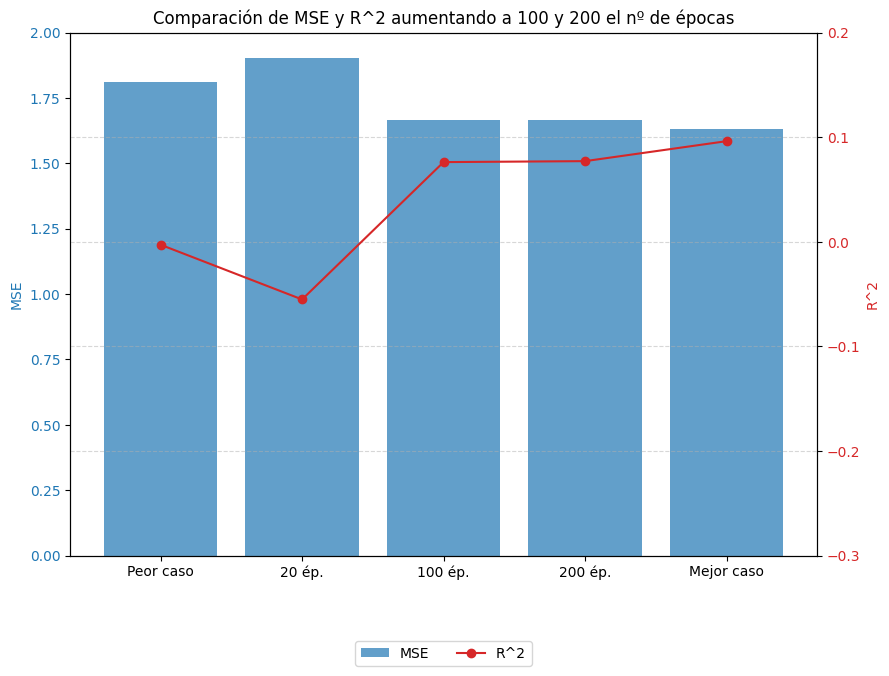

In [17]:
# Datos para la gráfica
mse_values = [mse_peor, mse_epocas, mse_100, mse_200, mse_mejor]
r2_values = [r2_peor, r2_epocas, r2_100, r2_200, r2_mejor]
labels = ['Peor caso', '20 ép.', '100 ép.', '200 ép.', 'Mejor caso']

# Crear la gráfica
fig, ax1 = plt.subplots()

# Barra para MSE en el eje y izquierdo (azul)
ax1.bar(labels, mse_values, color='tab:blue', label='MSE', alpha=0.7)
ax1.set_ylabel('MSE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 2)

# Crear un segundo eje y para R^2 (rojo)
ax2 = ax1.twinx()
ax2.plot(labels, r2_values, color='tab:red', marker='o', label='R^2')
ax2.set_ylabel('R^2', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(-0.3, 0.2)

# Ajustes adicionales
plt.title('Comparación de MSE y R^2 aumentando a 100 y 200 el nº de épocas')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar leyenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Mostrar la gráfica
plt.show()